In [53]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import neuromaps

In [54]:
print("neuromaps version:", neuromaps.__version__)

neuromaps version: 0.0.5+41.gf0ed67c


In [55]:
## run if needed
# pip install neuromaps brainspace
# pip install statsmodels

In [56]:
# Add more imports if needed

from neuromaps.datasets import fetch_atlas ## used to access the templates for the coordinate system
import nibabel as nib ## used to load system dictionary per key
from neuromaps.datasets import available_annotations ## repository of brain maps - spatial maps representing some
from neuromaps.datasets import available_tags ## most annotations have “tags” that help to describe the data they represent
from neuromaps.datasets import fetch_annotation
from neuromaps.datasets import fetch_fsaverage

from neuromaps import transforms
import netneurotools
# possibly need
from netneurotools import datasets as nntdata
from neuromaps import parcellate
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
# plotting 
from neuromaps.images import load_data
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from neuromaps import plotting
from nilearn import plotting
import numpy as np
import pandas as pd
# sampling
from neuromaps import datasets, images, nulls, resampling
from neuromaps.resampling import resample_images
from neuromaps.stats import compare_images
from neuromaps import stats
from nilearn.datasets import fetch_atlas_surf_destrieux
from neuromaps.nulls import alexander_bloch
from neuromaps.stats import compare_images
from scipy.stats import pearsonr

from nilearn.surface import load_surf_mesh
from brainspace.null_models import SpinPermutations
from nilearn.surface import InMemoryMesh, PolyMesh
from nilearn.surface import SurfaceImage
from nilearn.plotting import view_surf

import time
# from neuromaps.stats import fdr_correct
# for FDR
from statsmodels.stats.multitest import multipletests

In [57]:
for annotation in available_annotations():
    print(annotation)

('abagen', 'genepc1', 'fsaverage', '10k')
('aghourian2017', 'feobv', 'MNI152', '1mm')
('alarkurtti2015', 'raclopride', 'MNI152', '3mm')
('bedard2019', 'feobv', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'MNI152', '1mm')
('beliveau2017', 'az10419369', 'fsaverage', '164k')
('beliveau2017', 'cimbi36', 'MNI152', '1mm')
('beliveau2017', 'cimbi36', 'fsaverage', '164k')
('beliveau2017', 'cumi101', 'MNI152', '1mm')
('beliveau2017', 'cumi101', 'fsaverage', '164k')
('beliveau2017', 'dasb', 'MNI152', '1mm')
('beliveau2017', 'dasb', 'fsaverage', '164k')
('beliveau2017', 'sb207145', 'MNI152', '1mm')
('beliveau2017', 'sb207145', 'fsaverage', '164k')
('castrillon2023', 'cmrglc', 'MNI152', '3mm')
('ding2010', 'mrb', 'MNI152', '1mm')
('dubois2015', 'abp688', 'MNI152', '1mm')
('dukart2018', 'flumazenil', 'MNI152', '3mm')
('dukart2018', 'fpcit', 'MNI152', '3mm')
('fazio2016', 'madam', 'MNI152', '3mm')
('finnema2016', 'ucbj', 'MNI152', '1mm')
('gallezot2010', 'p943', 'MNI152', '1mm')
('gallezot2017',

#### Tuples for the brain maps we're going to use
**subject to change tho**

In [58]:
# other brain maps
# Physical maps
('abagen', 'genepc1', 'fsaverage', '10k')
('hcps1200', 'myelinmap', 'fsLR', '32k')
('hcps1200', 'thickness', 'fsLR', '32k')
('reardon2018', 'scalingnih', 'civet', '41k')
# Chemical maps
('savli2012', 'way100635', 'MNI152', '3mm') ## 5ht1a brain map
('margulies2016', 'fcgradient01', 'fsLR', '32k')
('raichle', 'cmrglc', 'fsLR', '164k')
('mueller2013', 'intersubjvar', 'fsLR', '164k')

('mueller2013', 'intersubjvar', 'fsLR', '164k')

In [59]:
# ## Maybe add more receptor maps
# ('smart2019', 'abp688', 'MNI152', '1mm') # ABP688 mGluR5 - controls the ability for the brain to rewire its connections and learn new things
# ('turtonen2020', 'carfentanil', 'MNI152', '1mm') # Carfentanil MOR - endorphins, responsible for feelings of euphoria & pain
# ...('kantonen2020', 'carfentanil', 'MNI152', '3mm')  #??

#### 5Ht1a brain map

get MNI data and transform it into fsLR 32k

ideally make everything into fsLR 32k

In [60]:
# mni152 = fetch_atlas('MNI152', '3mm')
# print(sorted(mni152))

In [61]:
five_ht1a = fetch_annotation(source='savli2012', desc='way100635', space='MNI152', den='3mm')


[References] Please cite the following papers if you are using this data:

  For {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}:
  [primary]:
    Markus Savli, Andreas Bauer, Markus Mitterhauser, Yu-Shin Ding, Andreas Hahn, Tina Kroll, Alexander Neumeister, Daniela Haeusler, Johanna Ungersboeck, Shannan Henry, and others. Normative database of the serotonergic system in healthy subjects using multi-tracer pet. Neuroimage, 63(1):447–459, 2012.
  [secondary]:
    


In [62]:
fslr_5ht1a = transforms.mni152_to_fslr(five_ht1a, '32k')
fslr_5ht1a
#The returned fslr object is a tuple of nib.GiftiImage objects corresponding to data from the (left, right) hemisphere. 
# These data can be accessed via the .agg_data() method on the image objects:

(<nibabel.gifti.gifti.GiftiImage at 0x30230d4d0>,
 <nibabel.gifti.gifti.GiftiImage at 0x16863b890>)

In [63]:
fslr_lh, fslr_rh = fslr_5ht1a
print(fslr_lh.agg_data().shape)

(32492,)


In [64]:
five_ht1a_data = load_data(fslr_5ht1a)
five_ht1a_data

array([37.421368, 27.300804, 23.448963, ..., 44.939358, 44.68842 ,
       43.892735], shape=(64984,), dtype=float32)

In [65]:
# fig = neuromaps.plotting.plot_surf_template(
#     data=fslr_5ht1a,
#     template='fsLR',
#     density='32k',
#     surf='inflated',          
#     cmap='plasma',
#     colorbar=True,
# )
# fig.suptitle("5HT1a (fsLR 32k)", fontsize=16, y=0.9)
# fig.show()

/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_45468/1722637415.py:15: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(
/var/folders/ff/1nvxwnl16fs1my8jhytzdqxw0000gn/T/ipykernel_45468/1722637415.py:30: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf(


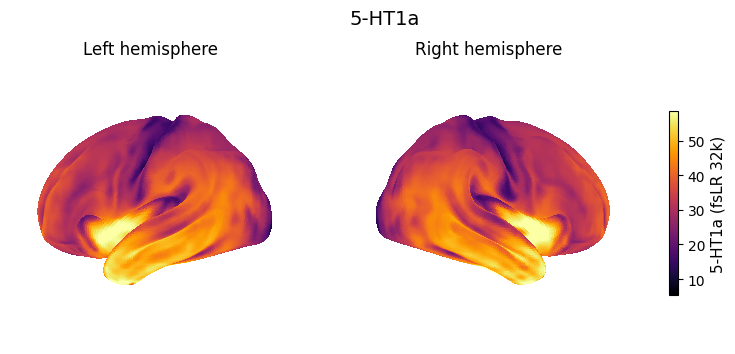

In [66]:
vmin, vmax = np.percentile(five_ht1a_data[~np.isnan(five_ht1a_data)], [2, 98])

# Fetch fsLR 32k surfaces
fslr = fetch_atlas('fsLR', density='32k')
surf_l = fslr['inflated'].L
surf_r = fslr['inflated'].R

data_l = load_data(fslr_5ht1a[0])
data_r = load_data(fslr_5ht1a[1])

fig = plt.figure(figsize=(10, 4))

# left hemi
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_l,
    surf_map=data_l,
    hemi='left',
    view='lateral',
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax1,
    title='Left hemisphere'
)

# right hemi
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
plotting.plot_surf(
    surf_mesh=surf_r,
    surf_map=data_r,
    hemi='right',
    view='lateral',
    cmap='inferno',
    vmin=vmin,
    vmax=vmax,
    colorbar=False,
    axes=ax2,
    title='Right hemisphere'
)
# color bar
sm = plt.cm.ScalarMappable(cmap='inferno')
sm.set_clim(vmin, vmax)
cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.6, location='right')
cbar.set_label('5-HT1a (fsLR 32k)', fontsize=11)

plt.suptitle("5-HT1a", fontsize=14)
plt.show()

## Fetch annotation and loading data

Transforming Brain maps into fsLR 32k if not already in this coordinate space

In [67]:
# PC1 Gene Expression
# The only case when we're transform upstream

pc1_gene = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
PC1_gene_exp = neuromaps.transforms.fsaverage_to_fslr(pc1_gene, '32k')
pc1_gene_data = load_data(PC1_gene_exp)


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


In [68]:
# Myelin Ratio
tw1_tw2_ratio = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
myelin_data = load_data(tw1_tw2_ratio)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


In [69]:
# Cortical Thickness
cort_thickness = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
cort_thickness_data = load_data(cort_thickness)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


In [70]:
# NIH Allometric Scaling
NIH_scaling = fetch_annotation(source='reardon2018', desc='scalingnih', space='civet', den='41k')
NIH_scaling_transform = neuromaps.transforms.civet_to_fslr(NIH_scaling, '32k')
NIH_scaling_data = load_data(NIH_scaling_transform)


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


In [71]:
# Functional Gradient
func_grad = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
func_gradient_data = load_data(func_grad)


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


In [72]:
# Glucose metabolism
gluc_metab = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR', den='164k')
gluc_metab_transform = neuromaps.transforms.fslr_to_fslr(gluc_metab, '32k')
gluc_metab_data = load_data(gluc_metab_transform)


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


In [73]:
# Intersubject Variability
intersub_var = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
intersub_var_transform = neuromaps.transforms.fslr_to_fslr(intersub_var, '32k')
intersub_var_data = load_data(intersub_var_transform)


[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    
